In [3]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer

### Read Source Data

In [5]:
patients = pd.read_csv('healthcare-dataset-stroke-data.csv')
patients = patients.drop('id', axis=1)
patients.head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


### Data Labeling

In [6]:
def label_data(data):
    df = data.copy()
    def encode_bool(x):
        return True if x==1 else False
    df.hypertension = df.hypertension.apply(encode_bool)
    df.heart_disease = df.heart_disease.apply(encode_bool)
    df.stroke = df.stroke.apply(encode_bool)
    
    df.ever_married = df.ever_married == "Yes"
    df['is_male'] = df.gender == "Male"
    df['is_urban'] = df['Residence_type'] == "Urban"
    df.drop(columns = ['gender', 'Residence_type'], inplace=True)
    df.smoking_status = df.smoking_status.map({"Unknown":np.NaN, "never smoked":0, "formerly smoked":1, "smokes":2})
    return df

labeled_data = label_data(patients)
labeled_data.head(10)

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke,is_male,is_urban
0,67.0,False,True,True,Private,228.69,36.6,1.0,True,True,True
1,61.0,False,False,True,Self-employed,202.21,NaN,0.0,True,False,False
2,80.0,False,True,True,Private,105.92,32.5,0.0,True,True,False
3,49.0,False,False,True,Private,171.23,34.4,2.0,True,False,True
4,79.0,True,False,True,Self-employed,174.12,24.0,0.0,True,False,False
5,81.0,False,False,True,Private,186.21,29.0,1.0,True,True,True
6,74.0,True,True,True,Private,70.09,27.4,0.0,True,True,False
7,69.0,False,False,False,Private,94.39,22.8,0.0,True,False,True
8,59.0,False,False,True,Private,76.15,NaN,NaN,True,False,False
9,78.0,False,False,True,Private,58.57,24.2,NaN,True,False,True


In [7]:
onehot_encoded = pd.get_dummies(labeled_data, columns=["work_type"])
onehot_encoded.head(10)

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,stroke,is_male,is_urban,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,67.0,False,True,True,228.69,36.6,1.0,True,True,True,0,0,1,0,0
1,61.0,False,False,True,202.21,NaN,0.0,True,False,False,0,0,0,1,0
2,80.0,False,True,True,105.92,32.5,0.0,True,True,False,0,0,1,0,0
3,49.0,False,False,True,171.23,34.4,2.0,True,False,True,0,0,1,0,0
4,79.0,True,False,True,174.12,24.0,0.0,True,False,False,0,0,0,1,0
5,81.0,False,False,True,186.21,29.0,1.0,True,True,True,0,0,1,0,0
6,74.0,True,True,True,70.09,27.4,0.0,True,True,False,0,0,1,0,0
7,69.0,False,False,False,94.39,22.8,0.0,True,False,True,0,0,1,0,0
8,59.0,False,False,True,76.15,NaN,NaN,True,False,False,0,0,1,0,0
9,78.0,False,False,True,58.57,24.2,NaN,True,False,True,0,0,1,0,0


### Data Transfomation & Dealing with Missing Values by KNN

In [8]:
onehot_encoded.isnull().sum()

age                           0
hypertension                  0
heart_disease                 0
ever_married                  0
avg_glucose_level             0
bmi                         201
smoking_status             1544
stroke                        0
is_male                       0
is_urban                      0
work_type_Govt_job            0
work_type_Never_worked        0
work_type_Private             0
work_type_Self-employed       0
work_type_children            0
dtype: int64

In [49]:
droped = onehot_encoded.dropna()
droped.reset_index(drop=True, inplace=True)
droped.isnull().sum()
droped.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,stroke,is_male,is_urban,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,67.0,False,True,True,228.69,36.6,1.0,True,True,True,0,0,1,0,0
1,80.0,False,True,True,105.92,32.5,0.0,True,True,False,0,0,1,0,0
2,49.0,False,False,True,171.23,34.4,2.0,True,False,True,0,0,1,0,0
3,79.0,True,False,True,174.12,24.0,0.0,True,False,False,0,0,0,1,0
4,81.0,False,False,True,186.21,29.0,1.0,True,True,True,0,0,1,0,0


In [50]:
# min_max_scaler = MinMaxScaler()
scaler = StandardScaler()
normalized = scaler.fit_transform(droped.drop('stroke', axis=1))

In [9]:
imputer = KNNImputer(n_neighbors=3)
filled = imputer.fit_transform(normalized)

In [52]:
columns = list(onehot_encoded.columns)
columns.remove('stroke')
preprocessed = pd.DataFrame(normalized, columns=columns)
preprocessed['stroke'] = droped['stroke']
preprocessed.head(5)

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,is_male,is_urban,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,stroke
0,0.973768,-0.367680,3.953615,0.564092,2.523621,0.864982,0.403745,1.248449,0.981491,-0.420132,-0.064056,0.746033,-0.474219,-0.142303,True
1,1.663479,-0.367680,3.953615,0.564092,-0.050358,0.302945,-0.836820,1.248449,-1.018858,-0.420132,-0.064056,0.746033,-0.474219,-0.142303,True
2,0.018784,-0.367680,-0.252933,0.564092,1.318923,0.563401,1.644309,-0.800994,0.981491,-0.420132,-0.064056,0.746033,-0.474219,-0.142303,True
3,1.610424,2.719753,-0.252933,0.564092,1.379514,-0.862253,-0.836820,-0.800994,-1.018858,-0.420132,-0.064056,-1.340423,2.108730,-0.142303,True
4,1.716533,-0.367680,-0.252933,0.564092,1.632992,-0.176842,0.403745,1.248449,0.981491,-0.420132,-0.064056,0.746033,-0.474219,-0.142303,True


In [53]:
preprocessed.isnull().sum()

age                        0
hypertension               0
heart_disease              0
ever_married               0
avg_glucose_level          0
bmi                        0
smoking_status             0
is_male                    0
is_urban                   0
work_type_Govt_job         0
work_type_Never_worked     0
work_type_Private          0
work_type_Self-employed    0
work_type_children         0
stroke                     0
dtype: int64

In [54]:
preprocessed.stroke.value_counts()

False    3246
True      180
Name: stroke, dtype: int64

In [55]:
preprocessed.to_csv('data-preprocessed(standardization).csv', index=False)

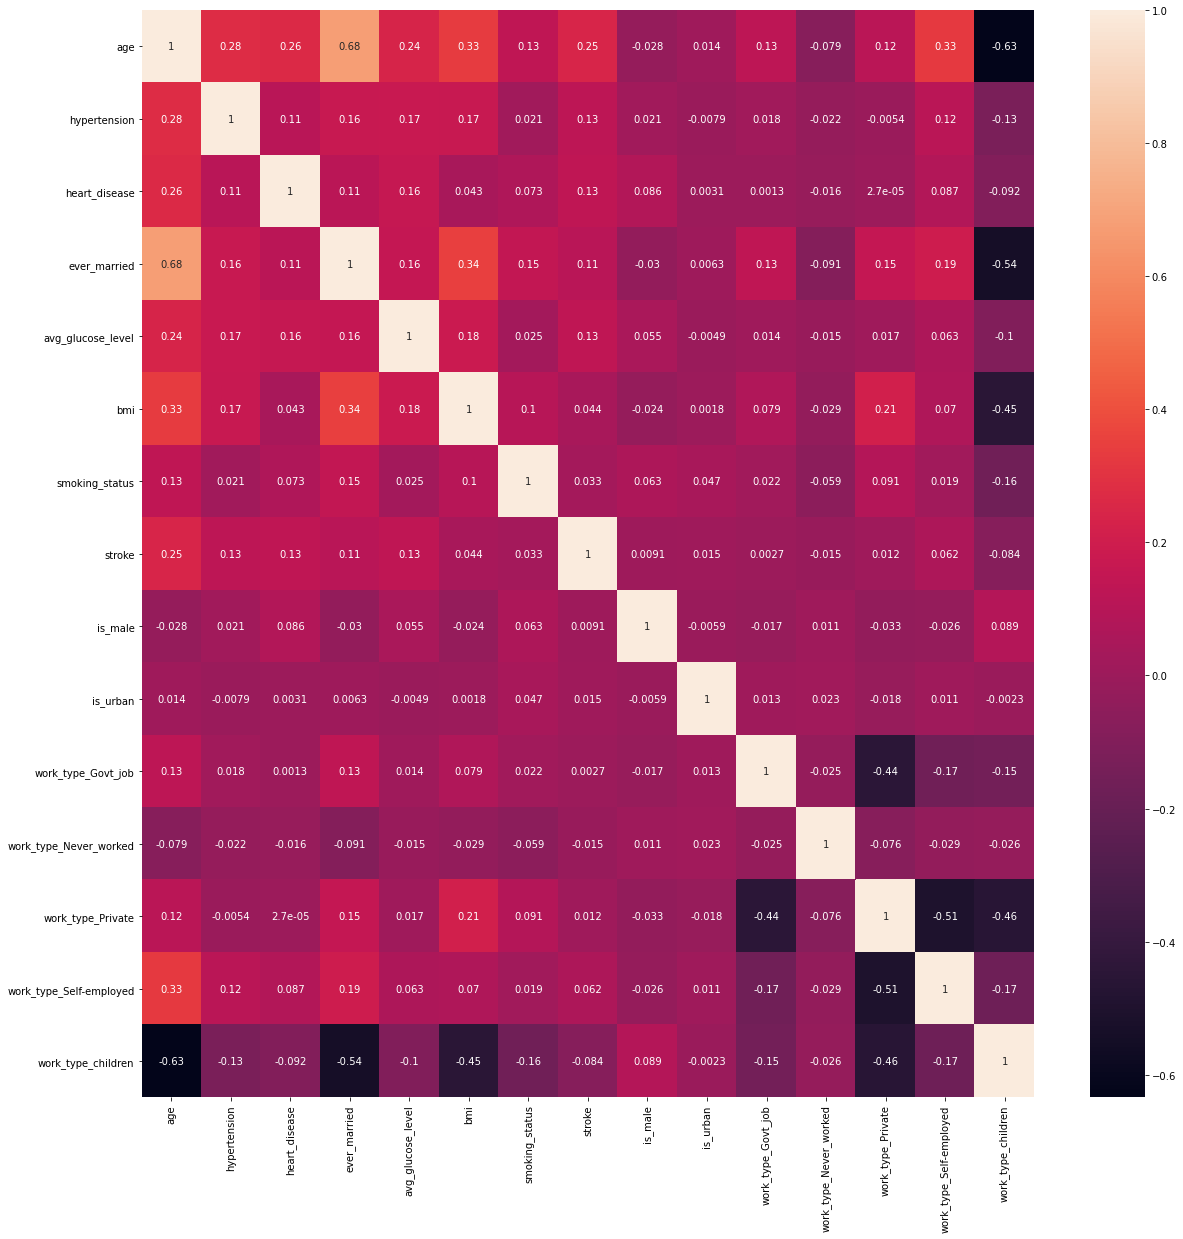

In [20]:
plt.figure(figsize=[20, 20])
hm = sb.heatmap(preprocessed.corr(), annot=True)

In [16]:
figure = hm.get_figure()    
figure.savefig('conf.png', dpi=300)

C:\Users\allen\anaconda3\envs\dataScience\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


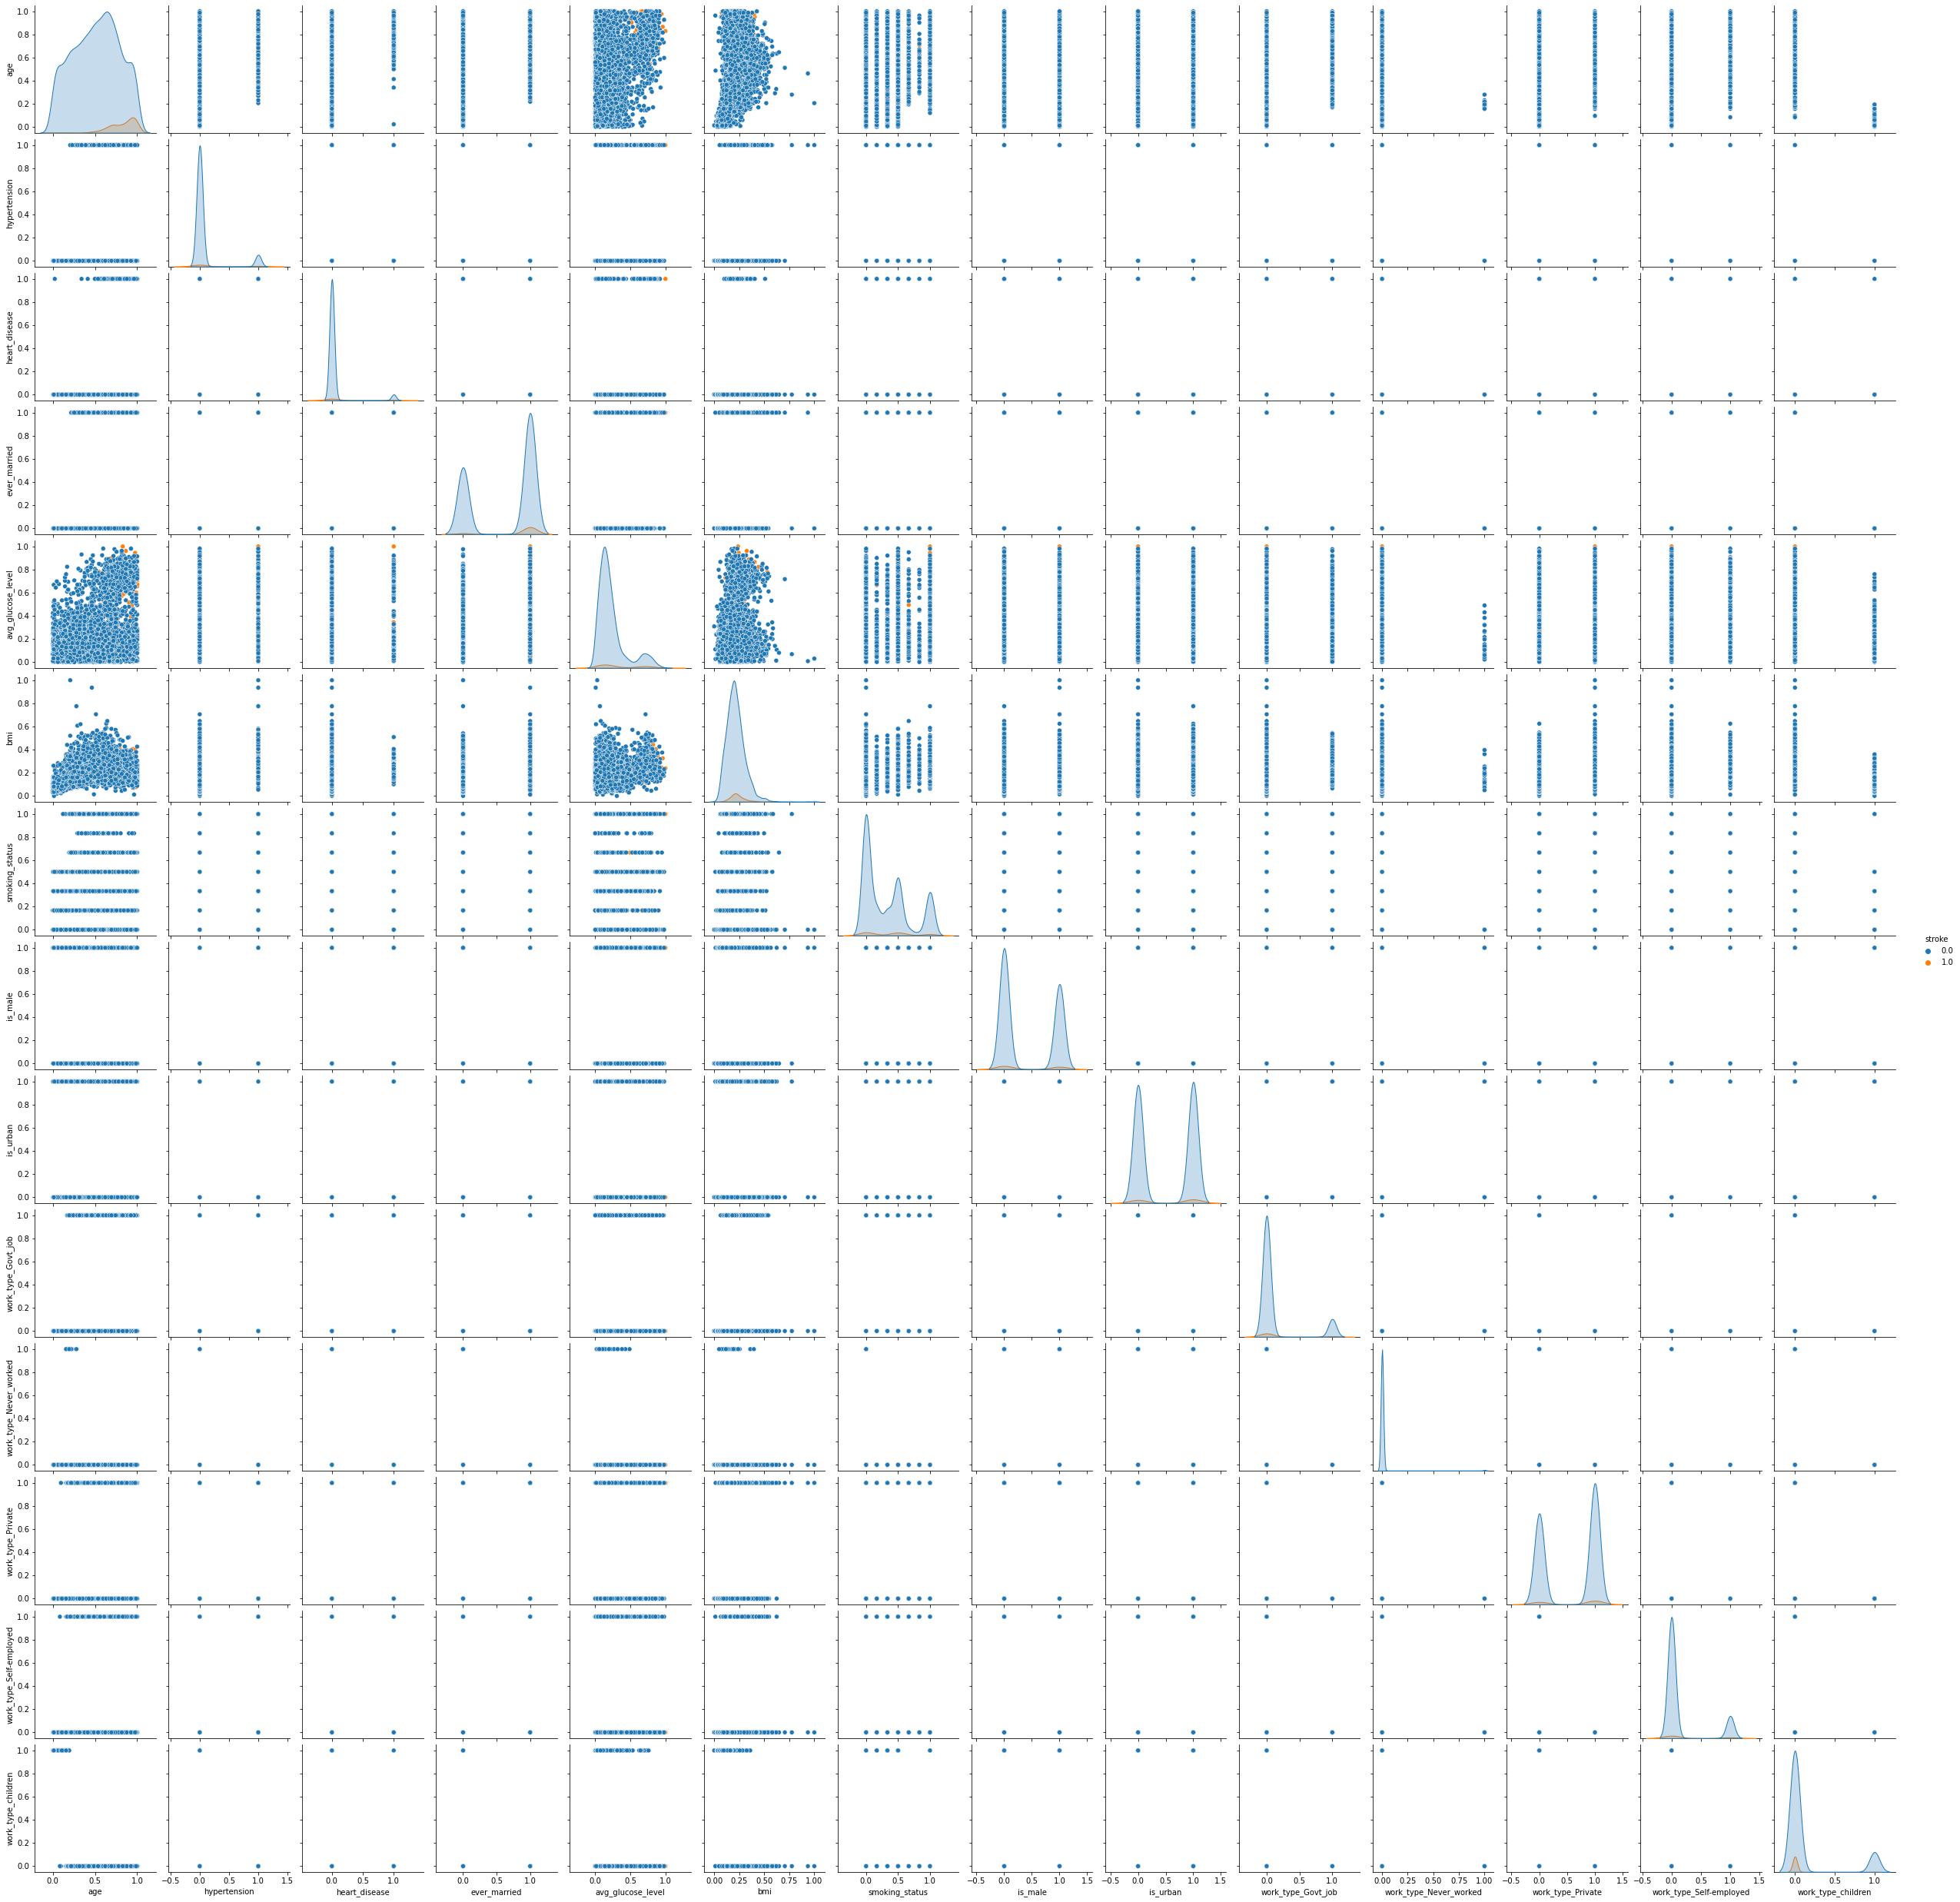

In [23]:
visualization = sb.pairplot(preprocessed, hue="stroke")

In [25]:
visualization.savefig("pairplot.png", dpi=300)

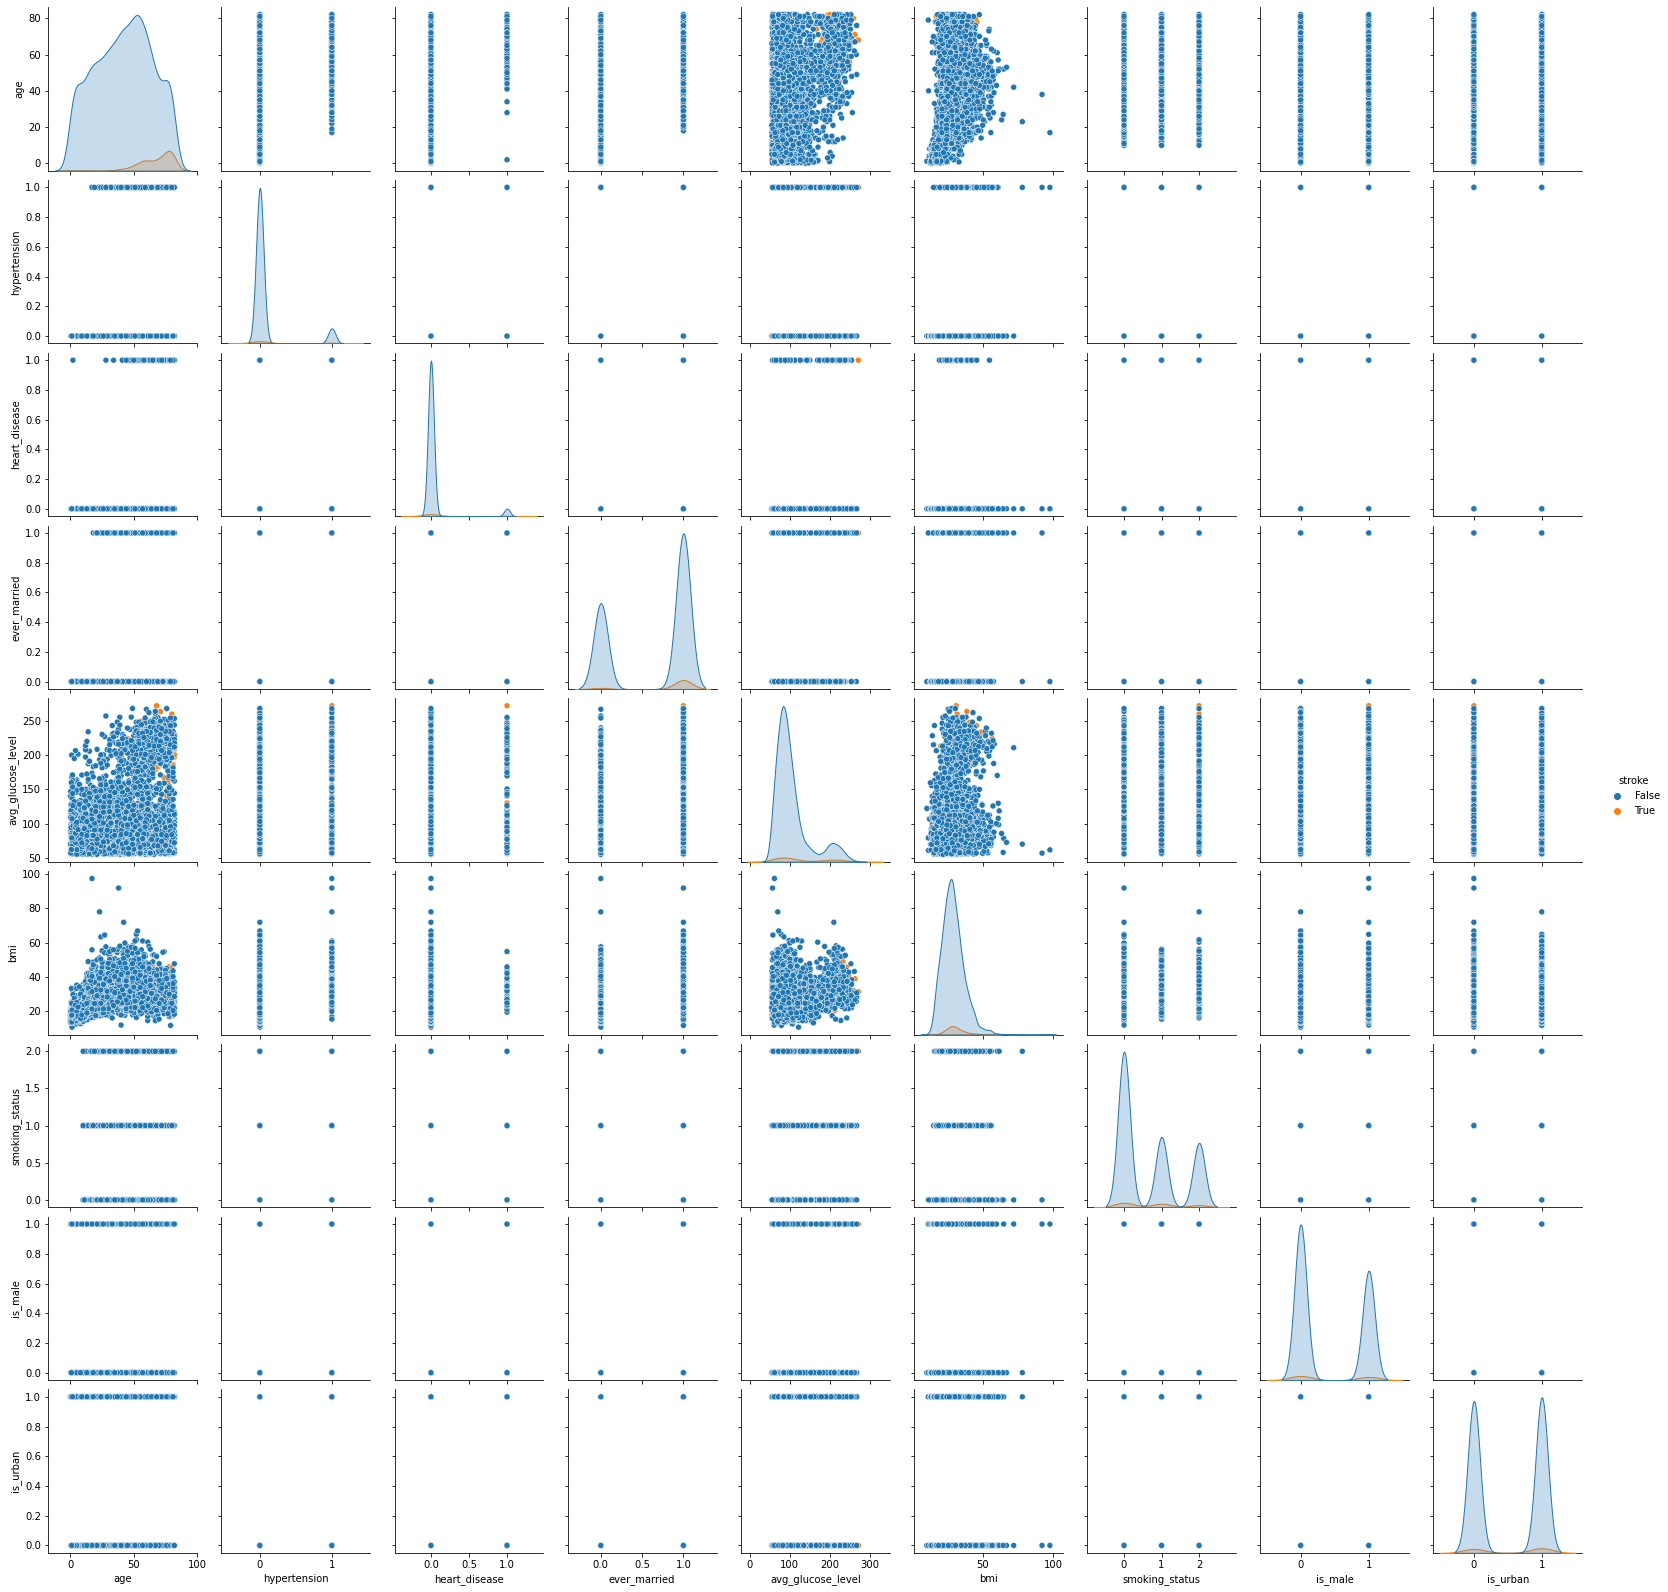

In [27]:
visualization = sb.pairplot(labeled_data, hue="stroke")

In [28]:
visualization.savefig("pairplot_label.png", dpi=300)

In [43]:
feature_seleted = preprocessed[["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi", "smoking_status", "stroke"]]
feature_seleted.sample(10, random_state=214)

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
1815,0.743652,0.0,0.0,0.028622,0.153494,1.000000,0.0
2745,0.230957,0.0,0.0,0.114025,0.180985,0.000000,0.0
3084,0.670410,0.0,0.0,0.264703,0.194731,0.000000,0.0
477,0.743652,0.0,0.0,0.595651,0.348606,0.166667,0.0
3186,0.829102,0.0,0.0,0.739590,0.191294,0.500000,0.0
4254,0.121094,0.0,0.0,0.102991,0.067583,0.166667,0.0
3087,0.072266,0.0,0.0,0.241344,0.084765,0.000000,0.0
4501,0.084473,0.0,0.0,0.104515,0.089347,0.500000,0.0
223,0.987793,0.0,0.0,0.070077,0.177549,1.000000,1.0
4260,0.780273,0.0,0.0,0.032730,0.206186,0.666667,0.0


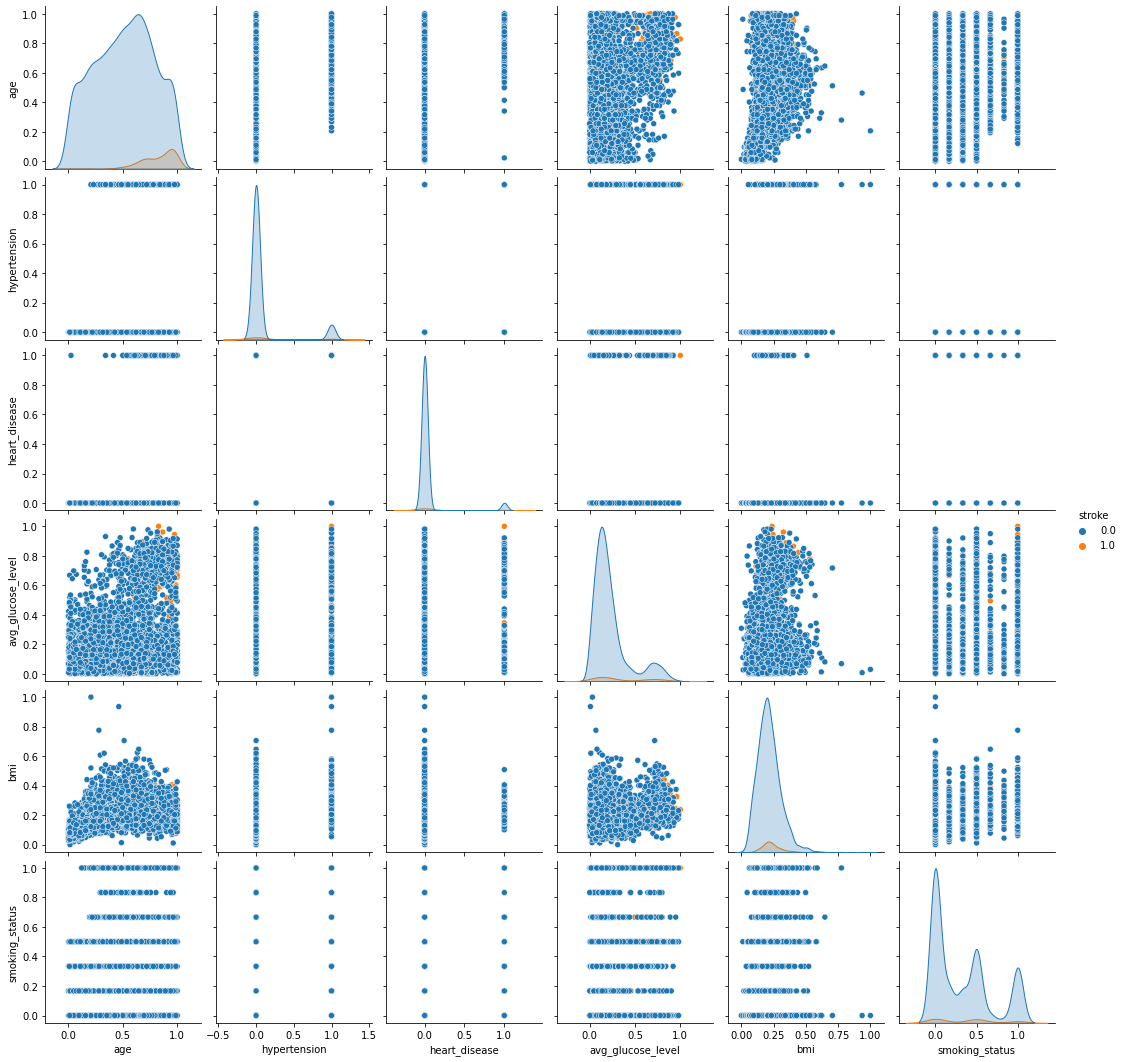

In [44]:
visualization_feature_seleted = sb.pairplot(feature_seleted, hue="stroke")

In [40]:
visualization_feature_seleted.savefig("pairplot_feature_selected.png", dpi=300)